In [20]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout

In [21]:
df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Ano', 'Mês', 'Dia']},
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [22]:
#filtra produto 'Alface Crespa - Roça', mantendo a coluna Preco_unitario
filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario']]

#agrupa por semana
filtered_alface_crespa_roca = filtered_alface_crespa_roca.resample('W').mean()

#preenche valores faltantes usando interpolação linear
filtered_alface_crespa_roca = filtered_alface_crespa_roca.interpolate(method='linear')

filtered_alface_crespa_roca.index.tz_localize("UTC").tz_convert("America/Sao_Paulo")

#identifica cada semana
filtered_alface_crespa_roca['week'] = filtered_alface_crespa_roca.index.strftime('%Y-w%V')

#ordena por data
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)
filtered_alface_crespa_roca

,Preco_unitario,week
dt,,
2016-04-24,0.61650,2016-w16
2016-05-01,0.42611,2016-w17
2016-05-08,0.43778,2016-w18
2016-05-15,0.43056,2016-w19
2016-05-22,0.44444,2016-w20
...,...,...
2023-08-27,0.40833,2023-w34
2023-09-03,0.37500,2023-w35
2023-09-10,0.35417,2023-w36


In [23]:
columns = ["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)","PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)","RADIACAO GLOBAL (Kj/m²)","TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","TEMPERATURA DO PONTO DE ORVALHO (°C)","TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)","TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)","TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)","TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)","UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)","UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)", "x"]

weather_df_2023 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2023_A_30-09-2023.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2023.columns = columns

weather_df_2022 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2022_A_31-12-2022.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2022.columns = columns

weather_df_2021 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2021_A_31-12-2021.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2021.columns = columns

weather_df_2020 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2020_A_31-12-2020.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2020.columns = columns

weather_df_2019 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2019_A_31-12-2019.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2019.columns = columns

#todo: ver como importar os dados de 2016, 2017 e 2018 (estão em outro formato)

weather_df = pd.concat([weather_df_2019, weather_df_2020, weather_df_2021, weather_df_2022, weather_df_2023])

#weather_df.columns = columns

weather_weekly_df = pd.DataFrame(weather_df[[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].resample('W').mean())
weather_weekly_df['week'] = weather_weekly_df.index.strftime('%Y-w%V')
#weather_df['RADIACAO GLOBAL (Kj/m²)']

<Axes: xlabel='dt'>

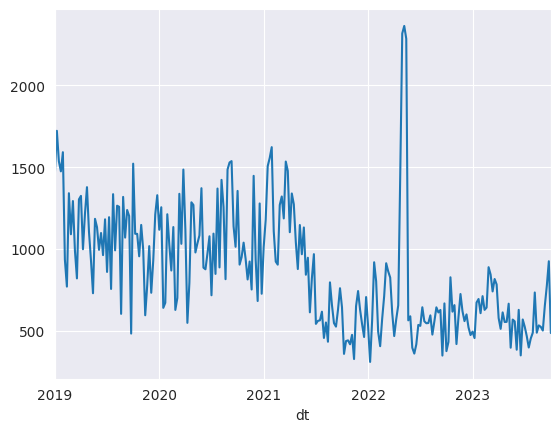

In [24]:
weather_weekly_df['RADIACAO GLOBAL (Kj/m²)'].plot()

<Axes: xlabel='dt'>

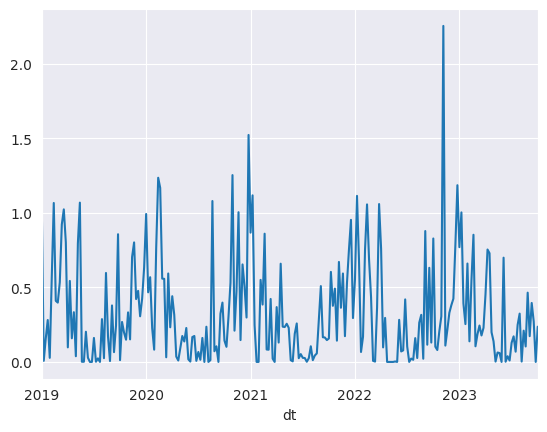

In [25]:
weather_weekly_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].plot()

Text(1.0, 0.75, '2021')

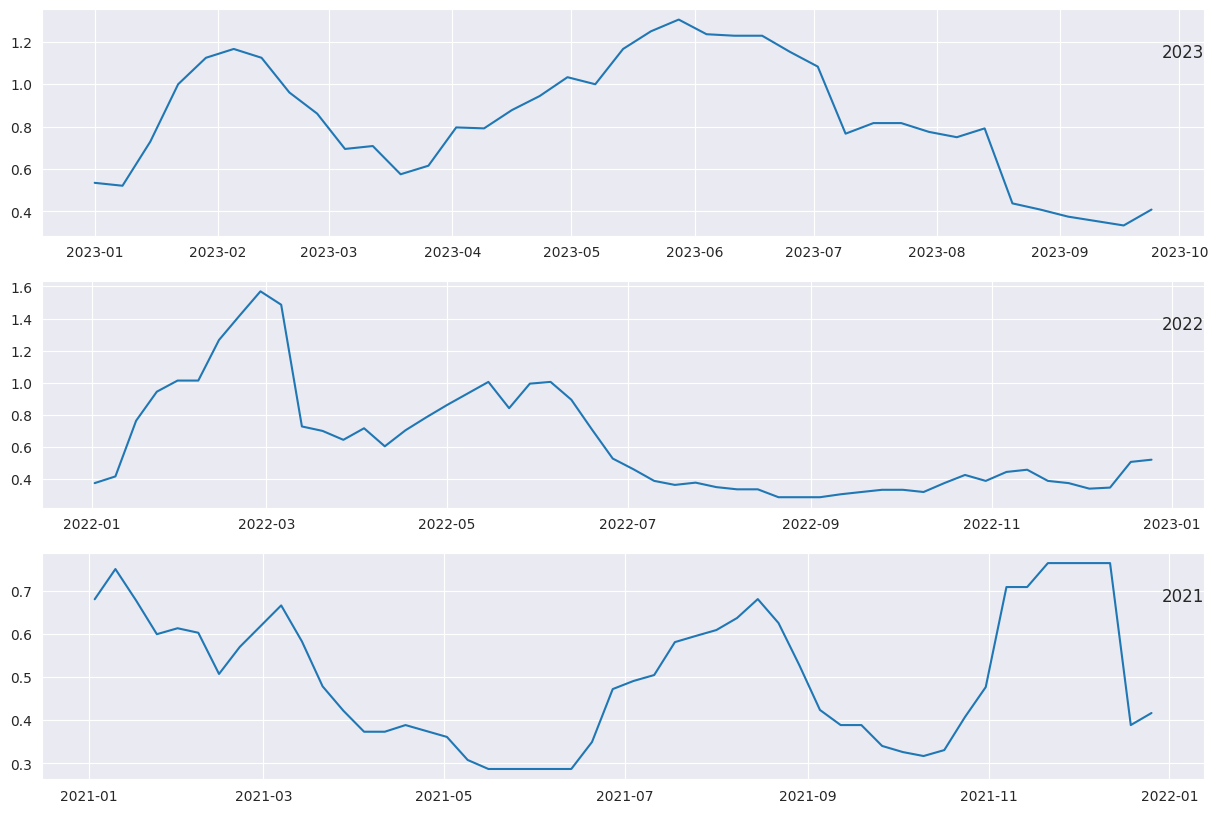

In [26]:
precos_2023 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2023-01-01')& (filtered_alface_crespa_roca.index < '2023-12-31')]

precos_2022 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2022-01-01')& (filtered_alface_crespa_roca.index < '2022-12-31')]


precos_2021 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2021-01-01')& (filtered_alface_crespa_roca.index < '2021-12-31')]

#.plot(title='Soma Preço unitário x Semana')
plt.figure(figsize=(15, 10))


plt.subplot(3, 1, 1)
plt.plot(precos_2023.Preco_unitario.resample('W').mean())
plt.title("2023", y=0.75, loc='right')

plt.subplot(3, 1, 2)
plt.plot(precos_2022.Preco_unitario.resample('W').mean())
plt.title("2022", y=0.75, loc='right')

plt.subplot(3, 1, 3)
plt.plot(precos_2021.Preco_unitario.resample('W').mean())
plt.title("2021", y=0.75, loc='right')

<Axes: xlabel='dt'>

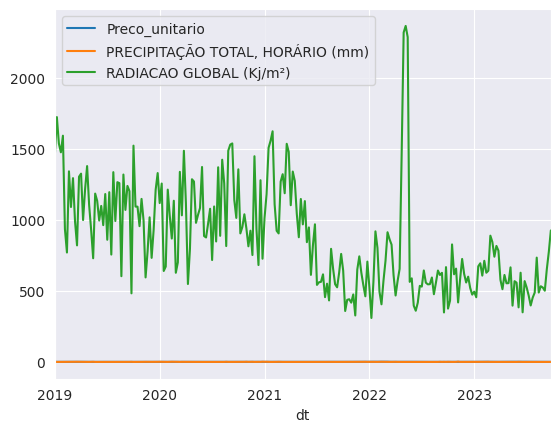

In [27]:
prices_after_2019 = filtered_alface_crespa_roca[filtered_alface_crespa_roca.index >= '2019-01-01']

price_weather_df = pd.merge(prices_after_2019, weather_weekly_df, on='week', how='left')
price_weather_df.index = prices_after_2019.index

price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].plot()



In [28]:

price_weather_numeric_df = price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']]

price_precipitation = price_weather_numeric_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']]

prediction_values = price_weather_df[['Preco_unitario']].values

train_size = 123
validation_size = 62
test_size = 62

values_train = prediction_values[0:train_size]
values_validation = prediction_values[train_size:train_size+validation_size]
values_test = prediction_values[train_size+validation_size:247]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(values_train)
scaled_validation = scaler.transform(values_validation)
scaled_test = scaler.transform(values_test)


In [29]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [30]:
in_size = 8
out_size = 8

reframed_train = series_to_supervised(scaled_train, in_size, out_size)
reframed_validation = series_to_supervised(scaled_validation, in_size, out_size)
reframed_test = series_to_supervised(scaled_test, in_size, out_size)
reframed_train

,var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7)
8,0.203361,0.308377,0.258713,0.280943,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841
9,0.308377,0.258713,0.280943,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841,0.442557
10,0.258713,0.280943,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841,0.442557,0.308377
11,0.280943,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841,0.442557,0.308377,0.064488
12,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841,0.442557,0.308377,0.064488,0.064488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.455153,0.548556,0.641959,0.544660,0.440702,0.459049,0.445146,0.317824,0.401220,0.465434,0.529649,0.418459,0.279462,0.204406,0.139357,0.139357
112,0.548556,0.641959,0.544660,0.440702,0.459049,0.445146,0.317824,0.401220,0.465434,0.529649,0.418459,0.279462,0.204406,0.139357,0.139357,0.159933
113,0.641959,0.544660,0.440702,0.459049,0.445146,0.317824,0.401220,0.465434,0.529649,0.418459,0.279462,0.204406,0.139357,0.139357,0.159933,0.141586
114,0.544660,0.440702,0.459049,0.445146,0.317824,0.401220,0.465434,0.529649,0.418459,0.279462,0.204406,0.139357,0.139357,0.159933,0.141586,0.123239


In [31]:
drop_cols = []
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[drop_cols], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[drop_cols], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[drop_cols], axis=1, inplace=True)
reframed_train

,var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7)
8,0.203361,0.308377,0.258713,0.280943,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841
9,0.308377,0.258713,0.280943,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841,0.442557
10,0.258713,0.280943,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841,0.442557,0.308377
11,0.280943,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841,0.442557,0.308377,0.064488
12,0.461451,0.641959,0.762796,0.777621,0.867314,0.957008,1.000000,0.938474,0.641959,0.595258,0.410680,0.375841,0.442557,0.308377,0.064488,0.064488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.455153,0.548556,0.641959,0.544660,0.440702,0.459049,0.445146,0.317824,0.401220,0.465434,0.529649,0.418459,0.279462,0.204406,0.139357,0.139357
112,0.548556,0.641959,0.544660,0.440702,0.459049,0.445146,0.317824,0.401220,0.465434,0.529649,0.418459,0.279462,0.204406,0.139357,0.139357,0.159933
113,0.641959,0.544660,0.440702,0.459049,0.445146,0.317824,0.401220,0.465434,0.529649,0.418459,0.279462,0.204406,0.139357,0.139357,0.159933,0.141586
114,0.544660,0.440702,0.459049,0.445146,0.317824,0.401220,0.465434,0.529649,0.418459,0.279462,0.204406,0.139357,0.139357,0.159933,0.141586,0.123239


In [32]:
#split into input and output
train_X, train_Y = reframed_train.values[:, :-8], reframed_train.values[:, -8:]
validation_X, validation_Y = reframed_validation.values[:, :-8], reframed_validation.values[:, -8:]
test_X, test_Y = reframed_test.values[:, :-8], reframed_test.values[:, -8:]


In [33]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(108, 1, 8) (108, 8) (47, 1, 8) (47, 8)


Epoch 1/100
2/2 - 5s - loss: 0.0913 - val_loss: 0.5127 - 5s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.0861 - val_loss: 0.4922 - 50ms/epoch - 25ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0808 - val_loss: 0.4724 - 51ms/epoch - 26ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0758 - val_loss: 0.4530 - 50ms/epoch - 25ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0709 - val_loss: 0.4341 - 53ms/epoch - 27ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0674 - val_loss: 0.4155 - 49ms/epoch - 25ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0639 - val_loss: 0.3972 - 53ms/epoch - 26ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0589 - val_loss: 0.3791 - 52ms/epoch - 26ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0550 - val_loss: 0.3614 - 49ms/epoch - 24ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0518 - val_loss: 0.3440 - 50ms/epoch - 25ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0490 - val_loss: 0.3271 - 58ms/epoch - 29ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0459 - val_loss: 0.3107 - 49ms/epoch - 25ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0426 - va

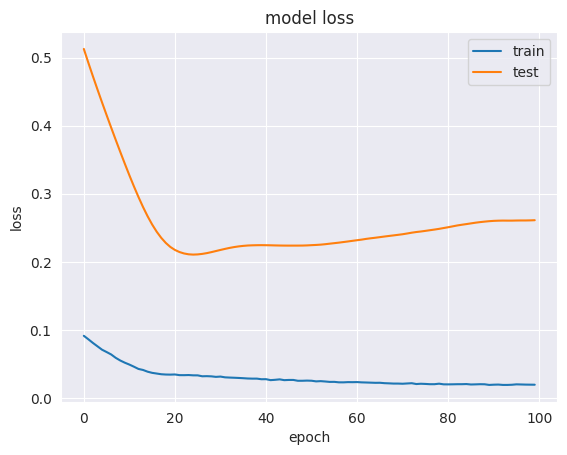

In [38]:

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(8))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_Y, epochs=100, batch_size=70, validation_data=(validation_X, validation_Y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [39]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 8))

2/2 [==============================] - 1s 6ms/step


In [43]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.493


2/2 [==============================] - 1s 5ms/step
Test RMSE: 0.125


<Axes: xlabel='dt'>

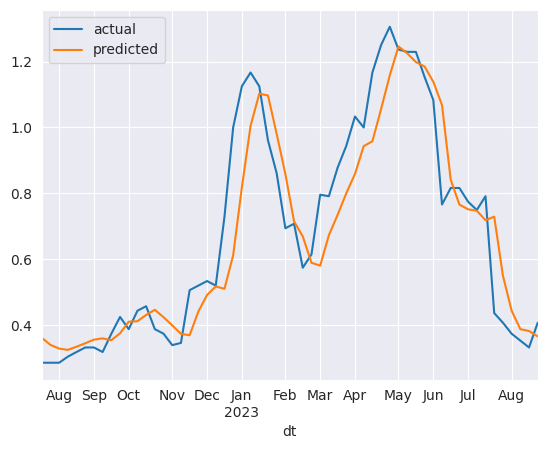

In [18]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = np.concatenate((test_Y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
comparison_df = pd.DataFrame({'actual': inv_y, 'predicted': inv_yhat}, index=price_weather_df.index[train_size+validation_size:243])
comparison_df.plot()

In [19]:
#X = test_X[0, :].reshape((1, 1, test_X.shape[2]))
#next_y = model.predict(X)
#yhat = [next_y]

#for i in range(len(test_Y)-1):
#	X = np.concatenate((X[:, :, 1:], next_y.reshape((1, 1, 1))), axis=2)
#	next_y = model.predict(X)
#	yhat.append(next_y)

#yhat = np.array(yhat).reshape((len(yhat), 1))
#test_X = test_X.reshape((test_X.shape[0], 4))

# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

# invert scaling for actual
#test_Y = test_Y.reshape((len(test_Y), 1))
#inv_y = np.concatenate((test_Y, test_X[:, -1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

# calculate RMSE
#rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
#comparison_df = pd.DataFrame({'actual': inv_y, 'predicted': inv_yhat}, index=price_weather_df.index[train_size+validation_size:243])
#comparison_df.plot()